In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import os
import torch.nn.functional as F

In [ ]:
# config
LEARNING_RATE = 1e-1 #0.01
SPLIT=0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4 # 5
EPOCHS = 7 # 7
NUM_WORKERS = 4 
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
PIN_MEMORY = True
DATAPATH = "/content/drive/Shareddrives/랜드마크/data/train"
TRAIN_IMG_DIR = '/content/drive/Shareddrives/랜드마크/data/train/3K_train_image'
TRAIN_MASK_DIR = '/content/drive/Shareddrives/랜드마크/data/train/3K_train_mask'

# VAL_IMG_DIR = 
# VAL_MASK_DIR = 

In [ ]:
import torch
import torch.nn as nn


def double_conv(in_c, out_c):
  conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True)
    )
  return conv.to(DEVICE)

In [ ]:
def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(DEVICE)
    return tensor_whose_shape_isTobechanged.to(DEVICE)

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.down_conv_1 = double_conv(3, 64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=1,
            kernel_size=1
        )

    def forward(self, image):
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        x = self.up_trans_1(x9)
        x = addPadding(x7, x)
        x = self.up_conv_1(torch.cat([x7, x], 1))

        x = self.up_trans_2(x)
        x = addPadding(x5, x)
        x = self.up_conv_2(torch.cat([x5, x], 1))

        x = self.up_trans_3(x)
        x = addPadding(x3, x)
        x = self.up_conv_3(torch.cat([x3, x], 1))

        x = self.up_trans_4(x)
        x = addPadding(x1, x)
        x = self.up_conv_4(torch.cat([x1, x], 1))

        x = self.out(x)
        
        return x.to(DEVICE)


In [ ]:
class hairpicDataSet(Dataset):
    def __init__(self,images,image_dir,mask_dir,transform=None,train=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.isTrain = train
        self.images = images
    def __len__(self):
        return len(self.images)
    def __getitem__(self,index):
        img_path = os.path.join(self.image_dir,self.images[index])
        mask_path = os.path.join(self.mask_dir,self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"),dtype=np.float32)
        mask[mask == 255.0] = 1.0
        
        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations['image']
            mask = augmentations['mask']
        return {"image":image,"mask":mask}

In [ ]:
images = os.listdir(TRAIN_IMG_DIR)
masks = os.listdir(TRAIN_MASK_DIR)

In [ ]:
def fit(model,dataloader,data,optimizer,criterion):
    print('-------------Training---------------')
    model.train()
    train_running_loss = 0.0
    counter=0
    
    # num of batches
    num_batches = int(len(data)/dataloader.batch_size)
    for i,data in tqdm(enumerate(dataloader),total=num_batches):
        counter+=1
        image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
        optimizer.zero_grad()
        outputs = model(image)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, mask)
        train_running_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/counter
    return train_loss
def validate(model,dataloader,data,criterion):
    print("\n--------Validating---------\n")
    model.eval()
    valid_running_loss = 0.0
    counter = 0
    # number of batches
    num_batches = int(len(data)/dataloader.batch_size)
    with torch.no_grad():
        for i,data in tqdm(enumerate(dataloader),total=num_batches):
            counter+=1
            image,mask = data["image"].to(DEVICE),data["mask"].to(DEVICE)
            outputs = model(image)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, mask)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss/counter
    return valid_loss

In [ ]:
pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 22.0 MB/s 
     |████████████████████████████████| 948 kB 59.0 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=584325225dd28e93db56ae1e4c1ef6e25f4f996760e20449ec2a6387ac6120f7
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2 

In [ ]:
from albumentations.core.composition import OneOf
train_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    OneOf([A.MotionBlur(),
           A.OpticalDistortion(),
           A.GaussNoise(p = 0.5),
           A.RandomContrast()]),
    A.ElasticTransform(),
    OneOf([A.HorizontalFlip(),
           A.RandomRotate90(),
           A.VerticalFlip()]),
    A.Normalize(
        mean=[0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0
    ),
    ToTensorV2()  
])
validation_transform = A.Compose([
    A.Resize(IMAGE_HEIGHT,IMAGE_WIDTH),
    A.Normalize(
        mean = [0.0,0.0,0.0],
        std = [1.0,1.0,1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2()
])

In [ ]:
def train_test_split(images,splitSize):
    imageLen = len(images)
    val_len = int(splitSize*imageLen)
    train_len = imageLen - val_len
    train_images,val_images = images[:train_len],images[train_len:]
    return train_images,val_images

In [ ]:
train_images_path,val_images_path = train_test_split(images,SPLIT)
train_data = hairpicDataSet(train_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,train_transform,True)
valid_data = hairpicDataSet(val_images_path,TRAIN_IMG_DIR,TRAIN_MASK_DIR,validation_transform,True)
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False)

Epoch 1 of 7
-------------Training---------------


100%|██████████| 600/600 [49:21<00:00,  4.94s/it]



--------Validating---------



100%|██████████| 150/150 [09:17<00:00,  3.72s/it]


Train Loss: 98107.1740
Val Loss: 96650.2454
Epoch 2 of 7
-------------Training---------------


100%|██████████| 600/600 [34:19<00:00,  3.43s/it]



--------Validating---------



100%|██████████| 150/150 [03:34<00:00,  1.43s/it]


Train Loss: 96041.6979
Val Loss: 95585.3882
Epoch 3 of 7
-------------Training---------------


100%|██████████| 600/600 [33:58<00:00,  3.40s/it]



--------Validating---------



100%|██████████| 150/150 [03:35<00:00,  1.43s/it]


Train Loss: 95462.9317
Val Loss: 95748.1326
Epoch 4 of 7
-------------Training---------------


100%|██████████| 600/600 [33:58<00:00,  3.40s/it]



--------Validating---------



100%|██████████| 150/150 [03:34<00:00,  1.43s/it]


Train Loss: 95768.9519
Val Loss: 96653.0199
Epoch 5 of 7
-------------Training---------------


100%|██████████| 600/600 [34:11<00:00,  3.42s/it]



--------Validating---------



100%|██████████| 150/150 [03:35<00:00,  1.43s/it]


Train Loss: 95474.8655
Val Loss: 95277.7072
Epoch 6 of 7
-------------Training---------------


100%|██████████| 600/600 [34:05<00:00,  3.41s/it]



--------Validating---------



100%|██████████| 150/150 [03:35<00:00,  1.44s/it]


Train Loss: 95136.7854
Val Loss: 95809.8545
Epoch 7 of 7
-------------Training---------------


100%|██████████| 600/600 [34:00<00:00,  3.40s/it]



--------Validating---------



100%|██████████| 150/150 [03:33<00:00,  1.42s/it]


Train Loss: 94742.7899
Val Loss: 94378.9983


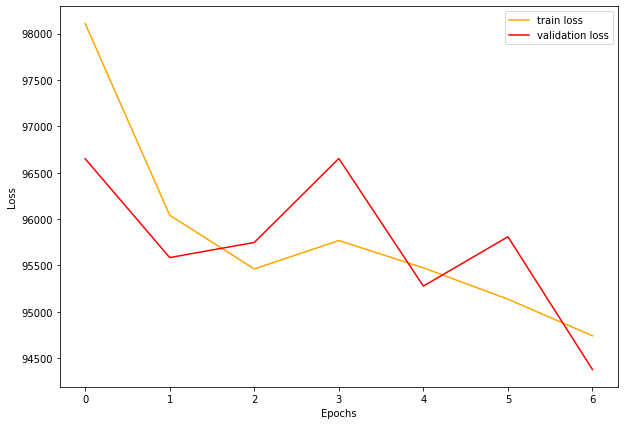


---------DONE TRAINING----------



In [ ]:
train_loss = []
val_loss =[]
model = UNet().to(DEVICE)
optimizer = optim.Adam(model.parameters(),lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1} of {EPOCHS}")
    train_epoch_loss = fit(model, train_dataloader, train_data,optimizer,criterion)
    val_epoch_loss = validate(model, valid_dataloader, valid_data, criterion)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {val_epoch_loss:.4f}')

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color="orange", label='train loss')
plt.plot(val_loss, color="red", label='validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
# plt.savefig(f"../input/loss.png")
plt.show()
torch.save({
    'epoch': EPOCHS,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': criterion,
}, "./model.pth")

print("\n---------DONE TRAINING----------\n")

In [ ]:
path = "/content/drive/Shareddrives/랜드마크/"
torch.save(model, path + '3kmodel2.pt')

In [ ]:
model2 = torch.load('/content/drive/Shareddrives/랜드마크/3kmodel2.pt')

torch.Size([3, 512, 512])
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([512, 512])


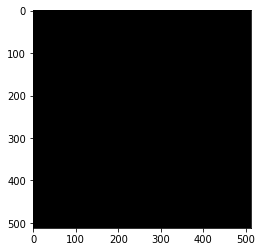

In [ ]:
data = valid_data.__getitem__(100)
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
output = model2(img)
output = torch.squeeze(output)
output[output>0] = 1.0
output[output<=0]=0
print(torch.max(output))
print(output.shape)
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")

torch.Size([3, 512, 512])
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([512, 512])


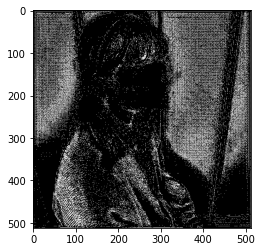

In [ ]:
model=UNet().to(DEVICE)
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
output = model(img)
output = torch.squeeze(output)
output[output>0.0] = 1.0
output[output<=0.0]=0
print(torch.max(output))
print(output.shape)
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")

In [ ]:
model=UNet().to(DEVICE)
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
output = model(img)
print(output)

torch.Size([3, 512, 512])
tensor([[[[-0.3426, -0.4748, -0.5436,  ...,  0.2003, -0.5393, -0.4998],
          [-0.7465, -0.1837, -0.6204,  ...,  0.0413,  0.3869, -0.5732],
          [-0.2084, -0.7248, -0.7619,  ..., -0.2173, -0.1453, -0.7143],
          ...,
          [-0.6818,  0.0311,  0.1057,  ..., -0.6493, -0.7840, -0.5135],
          [-0.0065, -0.1407,  0.1705,  ..., -0.1408, -0.5234,  0.2228],
          [-0.3615,  0.5533,  0.3374,  ...,  0.2896, -0.0649,  0.4389]]]],
       device='cuda:0', grad_fn=<AddBackward0>)


torch.Size([3, 512, 512])
tensor([[[[-1.6668e+00, -1.0307e+00, -1.2521e+00,  ..., -7.2889e-01,
           -4.8476e-02, -6.0671e-01],
          [-1.3274e+00, -1.6501e+00, -1.4899e-01,  ..., -9.5609e-01,
           -4.8512e-01, -9.3668e-02],
          [-1.1746e+00, -2.5491e+00, -1.3693e-01,  ..., -1.5192e+00,
           -2.0868e-03, -7.4674e-01],
          ...,
          [-1.6720e+00, -7.4096e-01, -1.1528e+00,  ..., -1.0610e+00,
           -2.0601e-01, -6.0045e-01],
          [-1.6056e+00, -6.5058e-01, -8.2531e-01,  ..., -6.4176e-01,
           -1.2737e+00, -4.9032e-01],
          [-2.9085e-01, -7.3792e-02, -5.1038e-01,  ..., -7.4891e-01,
           -1.2251e+00, -7.3848e-02]]]], device='cuda:0',
       grad_fn=<AddBackward0>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
torch.Size([512, 512])


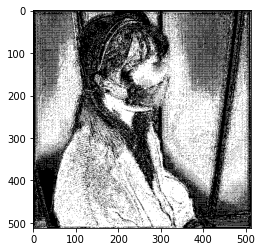

In [ ]:
model=UNet().to(DEVICE)
print(data['image'].shape)
img = data['image'].unsqueeze(0).to(device="cuda")
output = model(img)
print(output)
output = torch.squeeze(output)
output[output>-0.3] = 1.0
output[output<=-0.3]=0
print(torch.max(output))
print(output.shape)
disp = output.detach().cpu()
plt.imshow(disp,cmap="gray")